### SENTIMENT ANALYSIS OF TWITTER AND REDDIT COMMENTS

#### <b>1. Install requirement modules</b>

In [1]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


#### <b>2. Import libraries</b>

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns
import joblib

from data_preprocess import clean_text, rename_category
from model_evaluate import model_evaluate

#### <b>3. Import Dataset and process data</b>

<li>Import dataset</li>

In [3]:
df = pd.read_csv("./dataset/dataset.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 937854 entries, 0 to 937853
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Text      937854 non-null  object
 1   Language  937831 non-null  object
 2   Label     937854 non-null  object
dtypes: object(3)
memory usage: 21.5+ MB


<li>Data processing</li>

In [4]:
df = df[df['Language'] == 'en']
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 871310 entries, 0 to 937853
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Text      871310 non-null  object
 1   Language  871310 non-null  object
 2   Label     871310 non-null  object
dtypes: object(3)
memory usage: 26.6+ MB


In [5]:
df = df.sample(n=30000)
df.info()
# df["category"] = df['sentiment'].apply(rename_category)
# df['text'] = df['selected_text'] 
# df = df[['text','category']]
# df.drop
# df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30000 entries, 868968 to 602067
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Text      30000 non-null  object
 1   Language  30000 non-null  object
 2   Label     30000 non-null  object
dtypes: object(3)
memory usage: 937.5+ KB


In [6]:
# positive = df[df['category']==1]
# negative = df[df['category']==-1]
# neutral = df[df['category']==0]

# len(positive), len(negative), len(neutral)

positive = df[df['Label']== 'positive']
negative = df[df['Label']=='negative']
litigious = df[df['Label']=='litigious']
uncertainty = df[df['Label']=='uncertainty']
len(positive), len(negative), len(uncertainty), len(litigious)

df['text'] = df['Text']
df['category'] = df['Label']

<Axes: xlabel='category', ylabel='count'>

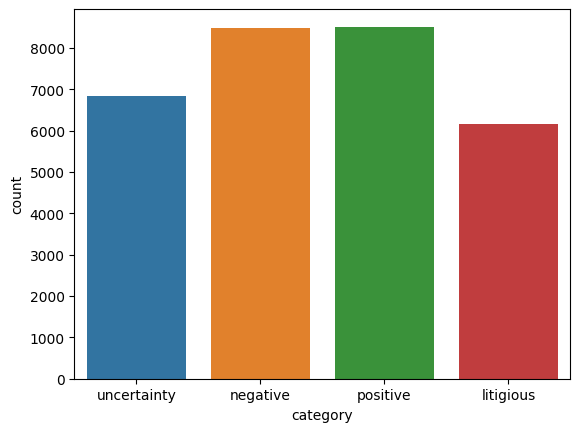

In [7]:
sns.countplot(x='category', data=df)

In [8]:
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_words(df['text'].values.astype('U').tolist(), 20)
data_frame = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
data_frame.groupby('ReviewText').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 words')


In [9]:
df = df[['text', 'category']]
df.to_csv("dataset/data_not_cleaned.csv")
df['cleaned_text'] = df['text'].apply(clean_text)
df = df[['cleaned_text', 'category']]
df.to_csv("dataset/data_cleaned.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30000 entries, 868968 to 602067
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   cleaned_text  30000 non-null  object
 1   category      30000 non-null  object
dtypes: object(2)
memory usage: 703.1+ KB


In [10]:
common_words = get_top_n_words(df['cleaned_text'].tolist(), 20)
data_frame = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
data_frame.groupby('ReviewText').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 words Combined')

#### <b>4. Converting text data into numerical features</b>

In [11]:
df['category'] = df['category'].apply(rename_category)
df.dropna()
X = df['cleaned_text']
y = df['category']
# vectorizer = TfidfVectorizer(ngram_range= (1,2), use_idf= True, sublinear_tf=True, max_features=50000)
vectorizer = TfidfVectorizer(use_idf= True, sublinear_tf=True)
# vectorizer =  TfidfVectorizer()
X_vector = vectorizer.fit_transform(X)
joblib.dump(vectorizer,"vectorizer.joblib")
X_vector

<30000x34767 sparse matrix of type '<class 'numpy.float64'>'
	with 385265 stored elements in Compressed Sparse Row format>

<li>Split the dataset into training and testing</li>

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X_vector, y, test_size=0.2, random_state=1)

X_train, X_test

(<24000x34767 sparse matrix of type '<class 'numpy.float64'>'
 	with 307871 stored elements in Compressed Sparse Row format>,
 <6000x34767 sparse matrix of type '<class 'numpy.float64'>'
 	with 77394 stored elements in Compressed Sparse Row format>)

#### <b>5. Training the classifier</b>

##### <li>Run SVM with default params</li>
> Default hyperparameter means C=1.0, kernel=rbf and gamma=auto among other parameters.



Fitting SVC took 180.99 seconds
Accuracy of model on training data : 99.7%
              precision    recall  f1-score   support

           0       0.98      0.95      0.96      1220
           1       0.96      0.93      0.95      1723
           2       0.97      0.96      0.96      1742
           3       0.92      0.97      0.95      1315

    accuracy                           0.95      6000
   macro avg       0.95      0.96      0.95      6000
weighted avg       0.96      0.95      0.95      6000

Accuracy of model on testing data: 95.45%


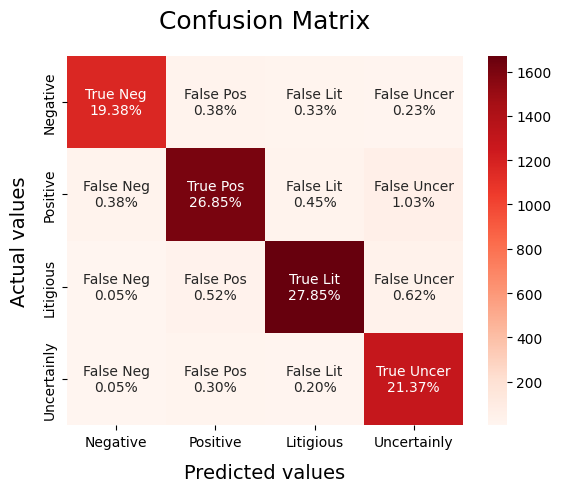

In [13]:
start_time = time.time()

svc_default = SVC()
svc_default.fit(X_train, y_train)

end_time = time.time()

process_time = round(end_time-start_time, 2)
print("Fitting SVC took {} seconds".format(process_time))
model_evaluate(svc_default,X_train, y_train, X_test, y_test)

##### <li>Run SVM with "rbf" kernel and C = 100.0</li>

Fitting SVC took 180.48 seconds
Accuracy of model on training data : 99.9625%
              precision    recall  f1-score   support

           0       0.98      0.95      0.96      1220
           1       0.95      0.94      0.95      1723
           2       0.97      0.96      0.96      1742
           3       0.93      0.97      0.95      1315

    accuracy                           0.96      6000
   macro avg       0.96      0.96      0.96      6000
weighted avg       0.96      0.96      0.96      6000

Accuracy of model on testing data: 95.6%


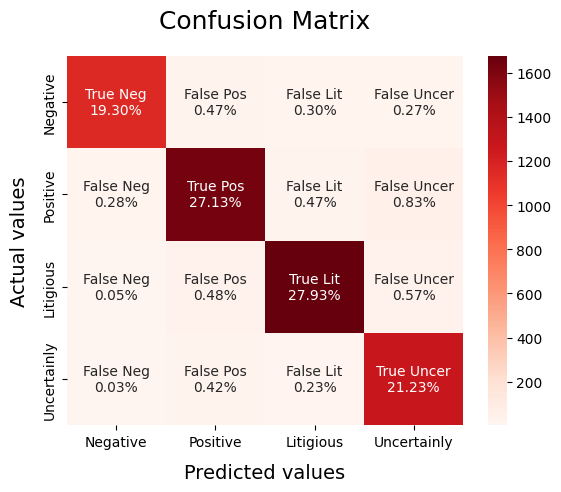

In [14]:
start_time = time.time()

svc_rbf_100 = SVC(C = 100.0, kernel= "rbf")
svc_rbf_100.fit(X_train, y_train)

end_time = time.time()
process_time = round(end_time-start_time, 2)
print("Fitting SVC took {} seconds".format(process_time))
model_evaluate(svc_rbf_100,X_train, y_train, X_test, y_test)

##### <li>Run SVM with "rbf" kernel and C = 1000.0</li>

Fitting SVC took 178.82 seconds
Accuracy of model on training data : 99.9625%
              precision    recall  f1-score   support

           0       0.98      0.95      0.96      1220
           1       0.95      0.94      0.95      1723
           2       0.97      0.96      0.96      1742
           3       0.93      0.97      0.95      1315

    accuracy                           0.96      6000
   macro avg       0.96      0.96      0.96      6000
weighted avg       0.96      0.96      0.96      6000

Accuracy of model on testing data: 95.6%


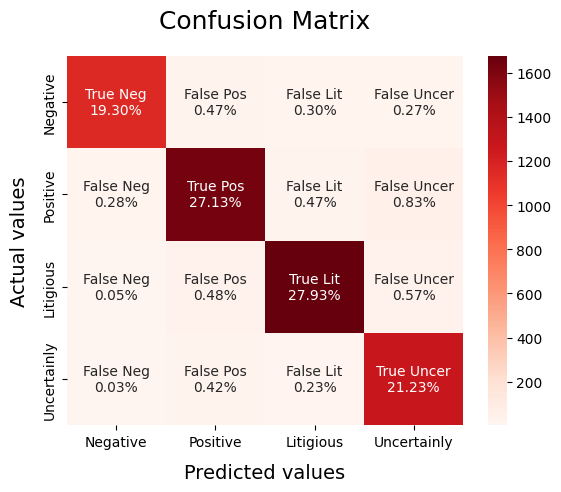

In [15]:
start_time = time.time()

svc_rbf_1000 = SVC(C = 1000.0, kernel= "rbf")
svc_rbf_1000.fit(X_train, y_train)

end_time = time.time()
process_time = round(end_time-start_time, 2)
print("Fitting SVC took {} seconds".format(process_time))
model_evaluate(svc_rbf_1000,X_train, y_train, X_test, y_test)

##### <li>Run SVM with "linear" kernel and C = 1.0</li>

Fitting SVC took 39.02 seconds
Accuracy of model on training data : 99.05416666666666%
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1220
           1       0.96      0.93      0.95      1723
           2       0.97      0.96      0.96      1742
           3       0.92      0.98      0.95      1315

    accuracy                           0.96      6000
   macro avg       0.96      0.96      0.96      6000
weighted avg       0.96      0.96      0.96      6000

Accuracy of model on testing data: 95.66666666666667%


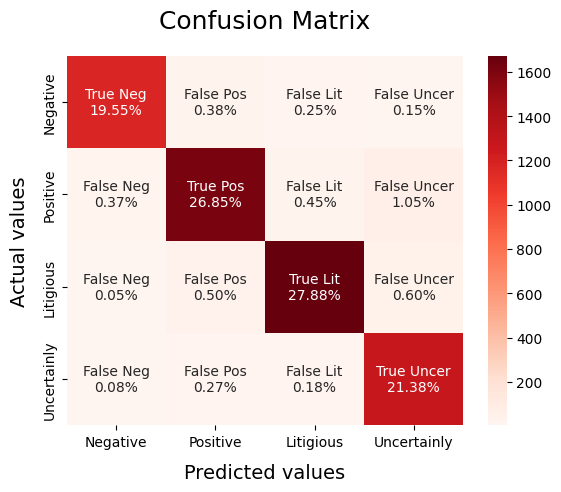

In [16]:
start_time = time.time()

svc_linear_1 = SVC(C = 1.0, kernel= "linear")
svc_linear_1.fit(X_train, y_train)

end_time = time.time()
process_time = round(end_time-start_time, 2)
print("Fitting SVC took {} seconds".format(process_time))

model_evaluate(svc_linear_1,X_train, y_train, X_test, y_test)

##### <li>Run SVM with "linear" kernel and C = 100.0</li>

Fitting SVC took 34.61 seconds
Accuracy of model on training data : 99.9625%
              precision    recall  f1-score   support

           0       0.95      0.96      0.95      1220
           1       0.93      0.93      0.93      1723
           2       0.96      0.95      0.95      1742
           3       0.93      0.94      0.94      1315

    accuracy                           0.94      6000
   macro avg       0.94      0.94      0.94      6000
weighted avg       0.94      0.94      0.94      6000

Accuracy of model on testing data: 94.36666666666666%


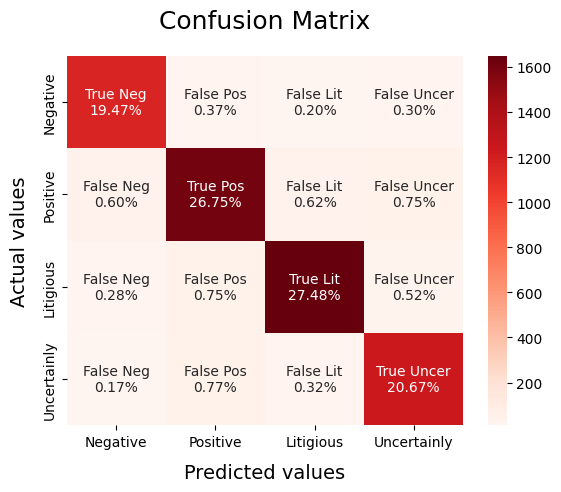

In [17]:
start_time = time.time()

svc_linear_100 = SVC(C = 100.0, kernel= "linear")
svc_linear_100.fit(X_train, y_train)

end_time = time.time()
process_time = round(end_time-start_time, 2)
print("Fitting SVC took {} seconds".format(process_time))

model_evaluate(svc_linear_100,X_train, y_train, X_test, y_test)

##### <li>Run SVM with "linear" kernel and C = 1000.0</li>

Fitting SVC took 32.68 seconds
Accuracy of model on training data : 99.9625%
              precision    recall  f1-score   support

           0       0.91      0.96      0.93      1220
           1       0.93      0.92      0.93      1723
           2       0.96      0.92      0.94      1742
           3       0.93      0.94      0.94      1315

    accuracy                           0.93      6000
   macro avg       0.93      0.94      0.93      6000
weighted avg       0.93      0.93      0.93      6000

Accuracy of model on testing data: 93.33333333333333%


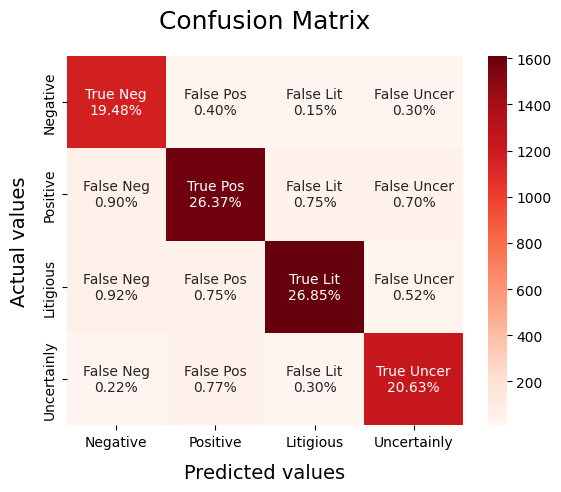

In [18]:
start_time = time.time()

svc_linear_1000 = SVC(C = 1000.0, kernel= "linear")
svc_linear_1000.fit(X_train, y_train)

end_time = time.time()
process_time = round(end_time-start_time, 2)
print("Fitting SVC took {} seconds".format(process_time))

model_evaluate(svc_linear_1000,X_train, y_train, X_test, y_test)

##### <li>Run SVM with "poly" kernel and C = 1.0</li>

Fitting SVC took 373.28 seconds
Accuracy of model on training data : 99.925%
              precision    recall  f1-score   support

           0       0.98      0.43      0.60      1220
           1       0.58      0.96      0.72      1723
           2       0.83      0.91      0.87      1742
           3       0.95      0.49      0.65      1315

    accuracy                           0.73      6000
   macro avg       0.83      0.70      0.71      6000
weighted avg       0.81      0.73      0.72      6000

Accuracy of model on testing data: 73.46666666666667%


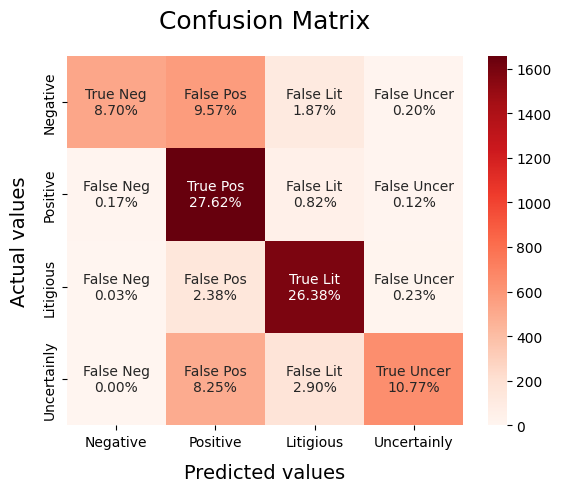

In [19]:
start_time = time.time()

svc_poly_1 = SVC(C = 1.0, kernel= "poly")
svc_poly_1.fit(X_train, y_train)

end_time = time.time()
process_time = round(end_time-start_time, 2)
print("Fitting SVC took {} seconds".format(process_time))

model_evaluate(svc_poly_1,X_train, y_train, X_test, y_test)

##### <li>Run SVM with "poly" kernel and C = 100.0</li>

Fitting SVC took 406.94 seconds
Accuracy of model on training data : 99.95416666666667%
              precision    recall  f1-score   support

           0       0.97      0.52      0.68      1220
           1       0.57      0.96      0.72      1723
           2       0.88      0.87      0.87      1742
           3       0.95      0.51      0.66      1315

    accuracy                           0.75      6000
   macro avg       0.84      0.72      0.73      6000
weighted avg       0.82      0.75      0.74      6000

Accuracy of model on testing data: 74.73333333333333%


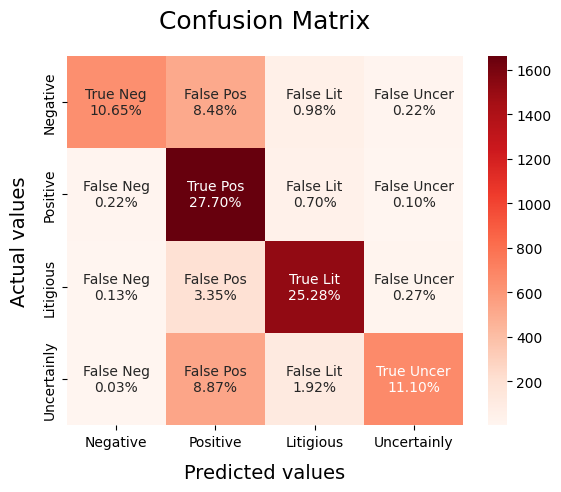

In [20]:
start_time = time.time()

svc_poly_100 = SVC(C = 100.0, kernel= "poly")
svc_poly_100.fit(X_train, y_train)

end_time = time.time()
process_time = round(end_time-start_time, 2)
print("Fitting SVC took {} seconds".format(process_time))

model_evaluate(svc_poly_100,X_train, y_train, X_test, y_test)

##### <li>Run SVM with "poly" kernel and C = 1000.0</li>

Fitting SVC took 409.03 seconds
Accuracy of model on training data : 99.9625%
              precision    recall  f1-score   support

           0       0.33      0.98      0.50      1220
           1       0.84      0.63      0.72      1723
           2       0.96      0.40      0.57      1742
           3       0.96      0.26      0.41      1315

    accuracy                           0.56      6000
   macro avg       0.77      0.57      0.55      6000
weighted avg       0.80      0.56      0.56      6000

Accuracy of model on testing data: 55.60000000000001%


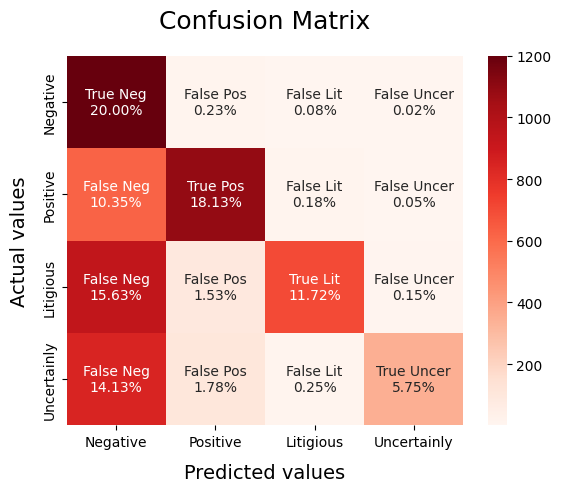

In [21]:
start_time = time.time()

svc_poly_1000 = SVC(C = 1000.0, kernel= "poly")
svc_poly_1000.fit(X_train, y_train)

end_time = time.time()
process_time = round(end_time-start_time, 2)
print("Fitting SVC took {} seconds".format(process_time))

model_evaluate(svc_poly_1000,X_train, y_train, X_test, y_test)

##### <li>Run SVM with "sigmoid" kernel and C = 1.0</li>

Fitting SVC took 34.33 seconds
Accuracy of model on training data : 97.95416666666667%
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1220
           1       0.96      0.93      0.95      1723
           2       0.97      0.96      0.96      1742
           3       0.92      0.98      0.95      1315

    accuracy                           0.96      6000
   macro avg       0.96      0.96      0.96      6000
weighted avg       0.96      0.96      0.96      6000

Accuracy of model on testing data: 95.61666666666667%


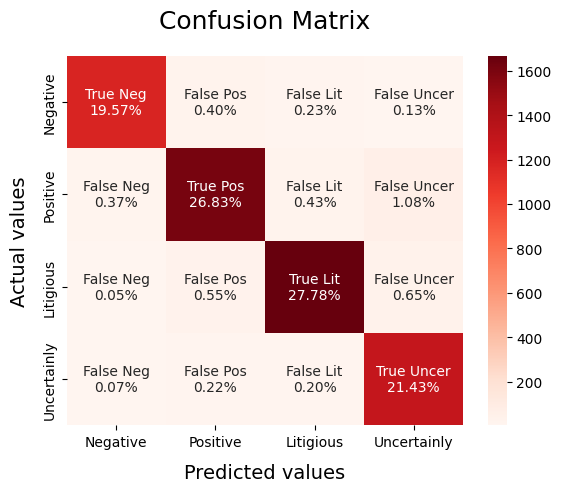

In [22]:
start_time = time.time()

svc_sigmoid_1 = SVC(C = 1.0, kernel= "sigmoid")
svc_sigmoid_1.fit(X_train, y_train)

end_time = time.time()
process_time = round(end_time-start_time, 2)
print("Fitting SVC took {} seconds".format(process_time))

model_evaluate(svc_sigmoid_1,X_train, y_train, X_test, y_test)

##### <li>Run SVM with "sigmoid" kernel and C = 100.0</li>

Fitting SVC took 16.95 seconds
Accuracy of model on training data : 99.45416666666667%
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      1220
           1       0.88      0.89      0.89      1723
           2       0.93      0.90      0.91      1742
           3       0.92      0.88      0.90      1315

    accuracy                           0.89      6000
   macro avg       0.89      0.89      0.89      6000
weighted avg       0.90      0.89      0.90      6000

Accuracy of model on testing data: 89.48333333333333%


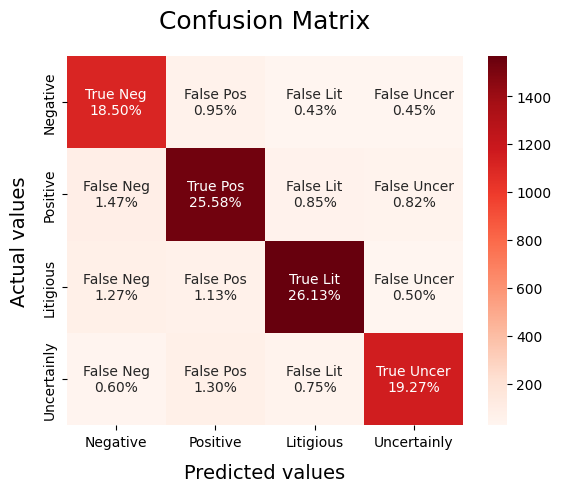

In [23]:
start_time = time.time()

svc_sigmoid_100 = SVC(C = 100.0, kernel= "sigmoid")
svc_sigmoid_100.fit(X_train, y_train)

end_time = time.time()
process_time = round(end_time-start_time, 2)
print("Fitting SVC took {} seconds".format(process_time))

model_evaluate(svc_sigmoid_100,X_train, y_train, X_test, y_test)

#### <b>6. Save the best model</b>

Our best model is SVM with "rbf" kernel and C = 100.0

In [24]:
joblib.dump(svc_rbf_100, "svc_rbf_100.joblib")

['svc_rbf_100.joblib']

In [25]:
model = joblib.load("svc_rbf_100.joblib")
vectorizer_load = joblib.load("vectorizer.joblib")

In [32]:
test = ["A teaspoon of raw honey in the morning has seriously helped me with my allergies this season Incredible"]
test_vec = vectorizer_load.transform(test)
model.predict(test_vec)


array([2], dtype=int64)